In [103]:
#%reset
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn import tree
from sklearn import metrics

from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score, confusion_matrix, matthews_corrcoef
from num2words import num2words
from sklearn.model_selection import RandomizedSearchCV, cross_val_score, KFold, RepeatedStratifiedKFold
from sklearn.metrics import f1_score, matthews_corrcoef, roc_auc_score
import word2number
from word2number import w2n
from sklearn.tree import DecisionTreeClassifier
import pickle
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import RocCurveDisplay
import random
from matplotlib.patches import Polygon

from Functions import prep_training_test_data_period, prep_training_test_data, calculate_metrics,cross_validation_leave_geo_out, prep_training_test_data_shifted, add_labels_to_subplots, LOOCV_by_HSA_dataset, save_in_HSA_dictionary
hfont = {'fontname':'Helvetica'}
palette = ['#66c2a5', '#fc8d62', '#8da0cb', '#e78ac3', '#a6d854', '#e5c494']


# Load data

In [104]:
HSA_weekly_data_all = pd.read_csv("/Users/rem76/Documents/COVID_projections/hsa_time_data_all_dates_weekly.csv")

# Polygons for mapping onto waves

In [105]:
## County Data 


data_by_county = pd.read_csv('/Users/rem76/Documents/COVID_projections/county_time_data_all_dates.csv')

data_by_county = data_by_county.dropna(subset=['admits_weekly', 'deaths_weekly', 'cases_weekly', 'icu_weekly', 'beds_weekly', 'perc_covid'])
data_by_county['CTYNAME'] = data_by_county['CTYNAME'].apply(lambda x: x.split()[0])
data_by_county['CTYNAME'] = data_by_county['fips'].astype(str) + '' + data_by_county['CTYNAME']
data_by_county['beds_over_15_100k'] = (data_by_county['beds_weekly'] > 15) * 1

# Redo dates
for i, week in enumerate(data_by_county['date'].unique()):
    data_by_county.loc[data_by_county['date'] == week, 'week'] = i

## DELTA POLYGON 

start_date = pd.to_datetime('2021-06-30')
end_date = pd.to_datetime('2021-10-26')
data_by_county['date'] = pd.to_datetime(data_by_county['date'])
for i, week in enumerate(data_by_county['date'].unique()):
    data_by_county.loc[data_by_county['date'] == week, 'week'] = i
# Find the indices of rows that match the exact start and end dates
matching_indices_start = data_by_county.loc[data_by_county['date'] <= start_date].index.max()
matching_indices_end = data_by_county.loc[data_by_county['date'] <= end_date].index.max()
first_week_delta = data_by_county.loc[matching_indices_start, 'week']
last_week_delta = data_by_county.loc[matching_indices_end, 'week']
start_date = pd.to_datetime('2021-10-26')
end_date = pd.to_datetime('2022-09-27')
data_by_county['date'] = pd.to_datetime(data_by_county['date'])
for i, week in enumerate(data_by_county['date'].unique()):
    data_by_county.loc[data_by_county['date'] == week, 'week'] = i
# Find the indices of rows that match the exact start and end dates
matching_indices_start = data_by_county.loc[data_by_county['date'] <= start_date].index.max()
matching_indices_end = data_by_county.loc[data_by_county['date'] <= end_date].index.max()
first_week_omricon = data_by_county.loc[matching_indices_start, 'week']
last_week_omricon = data_by_county.loc[matching_indices_end, 'week']

## CDC POLYGON 
start_date = pd.to_datetime('2021-03-01')
end_date = pd.to_datetime('2022-01-24')
data_by_county['date'] = pd.to_datetime(data_by_county['date'])
for i, week in enumerate(data_by_county['date'].unique()):
    data_by_county.loc[data_by_county['date'] == week, 'week'] = i
# Find the indices of rows that match the exact start and end dates
matching_indices_start = data_by_county.loc[data_by_county['date'] <= start_date].index.max()
matching_indices_end = data_by_county.loc[data_by_county['date'] <= end_date].index.max()
first_week_CDC = data_by_county.loc[matching_indices_start, 'week']
last_week_CDC = data_by_county.loc[matching_indices_end, 'week']

/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_92713/4200828156.py:4: DtypeWarning: Columns (47,48,49,50,51,55,56) have mixed types. Specify dtype option on import or set low_memory=False.
  data_by_county = pd.read_csv('/Users/rem76/Documents/COVID_projections/county_time_data_all_dates.csv')


# Percentage exceeding capacity 

In [107]:
percent_exceed_capacity = []

# Iterate through the columns of the DataFrame
for column_name in HSA_weekly_data_all.columns:
    if 'beds_over_15_100k' in column_name:
        # Calculate the sum of the column and append it to the list
        column_sum = HSA_weekly_data_all[column_name].sum()/len(HSA_weekly_data_all[column_name])
        percent_exceed_capacity.append(column_sum)

# Metrics - 10 week model w/ test on one week

In [108]:
no_iterations = 10
geography_column = 'HSA_ID'  
geo_split = 0.9  
time_period = 'period'  # Choose 'period', 'exact', or 'shifted'
size_of_test_dataset = 1

weeks_in_future = 3 
weight_col = 'weight'  
keep_output = True  
no_iterations_param = 100  # Replace with the number of iterations for RandomizedSearchCV
param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': np.arange(2, 5, 1),
    'min_samples_split': np.arange(200, 2000, 50), #[100, 200, 300, 400, 500], #np.arange(50, 200),
    'min_samples_leaf':  np.arange(200, 2000, 50)} #100, 200, 300, 400, 500], #np.arange(500, 200)
    #'ccp_alpha': np.arange(0.0001, 0.0035, 0.0001) }

# Create the Decision Tree classifier
cv = RepeatedStratifiedKFold(n_splits=10,  n_repeats=10,random_state=1) ## 10-fold cross validations
weeks_to_predict_ten_week = range(1, 121 - 1 - 3 - 10)


In [253]:
ROC_by_week_full_period_10_week = []
sensitivity_by_week_full_period_10_week = []
specificity_by_week_full_period_10_week = []
ppv_by_week_full_period_10_week = []
npv_by_week_full_period_10_week = []
accuracy_by_week_full_period_10_week = []
accuracy_by_week_full_period_10_week = []
norm_MCC_by_week_full_period_10_week = []

size_of_test_dataset = 1
for prediction_week in weeks_to_predict_ten_week:
    print(prediction_week)
    model_name_to_load = "/Users/rem76/Documents/COVID_projections/10_week_models/Full_model_" + time_period + "_" + str(prediction_week) + ".sav"
    clf_full_period = pickle.load(open(model_name_to_load, 'rb'))

    X_train_full_period, y_train_full_period, weights_full_period, missing_data_train_HSA = prep_training_test_data_period(HSA_weekly_data_all, no_weeks=range(prediction_week, int(prediction_week + 10) + 1), weeks_in_future=3, geography='HSA_ID', weight_col='weight', keep_output=True)

    X_test_full_period, y_test_full_period, weights_test_full_period, missing_data_test_HSA = prep_training_test_data_period(HSA_weekly_data_all, no_weeks=range(int(prediction_week + 10) + 1, int(prediction_week + 10 + size_of_test_dataset) + 1), weeks_in_future=3, geography='HSA_ID', weight_col='weight', keep_output=True)
    weights_full_period = weights_full_period[0].to_numpy()


    clf_full_period.fit(X_train_full_period, y_train_full_period, sample_weight=weights_full_period)

    # Make predictions on the test set
    y_pred = clf_full_period.predict(X_test_full_period)
    y_pred_proba = clf_full_period.predict_proba(X_test_full_period)

    # Evaluate the accuracy of the model
    accuracy_by_week_full_period_10_week.append(accuracy_score(y_test_full_period, y_pred))
    ROC_by_week_full_period_10_week.append(roc_auc_score(y_test_full_period, y_pred_proba[:, 1]))
    conf_matrix = confusion_matrix(y_test_full_period, y_pred)


    sensitvity, specificity, ppv, npv = calculate_metrics(conf_matrix)
    specificity_by_week_full_period_10_week.append(specificity)
    # Calculate sensitivity (true positive rate)
    sensitivity_by_week_full_period_10_week.append(sensitvity)

    ppv_by_week_full_period_10_week.append(ppv)
    npv_by_week_full_period_10_week.append(npv)
    norm_MCC_by_week_full_period_10_week.append((matthews_corrcoef(y_test_full_period, y_pred) + 1)/2)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106


# Metrics - 6 month models

In [110]:
no_iterations = 10
geography_column = 'HSA_ID'  
geo_split = 0.9  
time_period = 'period'  # Choose 'period', 'exact', or 'shifted'
no_weeks_train =  range(1, int(26) + 1)  # First 6 months initially 
no_weeks_test = range(26, int(26 + 13) + 1)  # Next three months
weeks_in_future = 3 
weight_col = 'weight'  
keep_output = True  
no_iterations_param = 50  # Replace with the number of iterations for RandomizedSearchCV
param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': np.arange(2, 5, 1),
    'min_samples_split': np.arange(200, 2000, 50), #[100, 200, 300, 400, 500], #np.arange(50, 200),
    'min_samples_leaf':  np.arange(200, 2000, 50)} #100, 200, 300, 400, 500], #np.arange(500, 200)
    #'ccp_alpha': np.arange(0.0001, 0.0035, 0.0001) }

# Create the Decision Tree classifier
cv = RepeatedStratifiedKFold(n_splits=10,  n_repeats=10,random_state=1) ## 10-fold cross validations

In [188]:
weeks_to_predict = range(1, 121 - 1 - 3 - 26) # 1 for the outcome week, 1 for the outcome period, 26 for the initial model
ROC_by_week_full_period_26_week = []
sensitivity_by_week_full_period_26_week = []
specificity_by_week_full_period_26_week = []
ppv_by_week_full_period_26_week = []
npv_by_week_full_period_26_week = []
accuracy_by_week_full_period_26_week = []
norm_MCC_by_week_full_period_26_week = []

size_of_test_dataset = 1
for prediction_week in weeks_to_predict:
    print(prediction_week)
    model_name_to_load = "/Users/rem76/Documents/COVID_projections/Six_month_models/Full_model_" + time_period + "_" + str(prediction_week) + ".sav"
    clf_full_period = pickle.load(open(model_name_to_load, 'rb'))

    X_train_full_period, y_train_full_period, weights_full_period, missing_data_train_HSA = prep_training_test_data_period(HSA_weekly_data_all, no_weeks=range(prediction_week, int(prediction_week + 26) + 1), weeks_in_future=3, geography='HSA_ID', weight_col='weight', keep_output=True)

    X_test_full_period, y_test_full_period, weights_test_full_period, missing_data_test_HSA = prep_training_test_data_period(HSA_weekly_data_all, no_weeks=range(int(prediction_week + 26) + 1, int(prediction_week + 26 + size_of_test_dataset) + 1), weeks_in_future=3, geography='HSA_ID', weight_col='weight', keep_output=True)
    weights_full_period = weights_full_period[0].to_numpy()


    clf_full_period.fit(X_train_full_period, y_train_full_period, sample_weight=weights_full_period)

    # Make predictions on the test set
    y_pred = clf_full_period.predict(X_test_full_period)
    y_pred_proba = clf_full_period.predict_proba(X_test_full_period)

    # Evaluate the accuracy of the model
    accuracy_by_week_full_period_26_week.append(accuracy_score(y_test_full_period, y_pred))
    ROC_by_week_full_period_26_week.append(roc_auc_score(y_test_full_period, y_pred_proba[:, 1]))
    conf_matrix = confusion_matrix(y_test_full_period, y_pred)

    accuracy_by_week_full_period_26_week.append(accuracy_score(y_test_full_period, y_pred))

    sensitvity, specificity, ppv, npv = calculate_metrics(conf_matrix)
    specificity_by_week_full_period_26_week.append(specificity)
    # Calculate sensitivity (true positive rate)
    sensitivity_by_week_full_period_26_week.append(sensitvity)

    ppv_by_week_full_period_26_week.append(ppv)
    npv_by_week_full_period_26_week.append(npv)
    norm_MCC_by_week_full_period_26_week.append((matthews_corrcoef(y_test_full_period, y_pred) + 1)/2)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83


FileNotFoundError: [Errno 2] No such file or directory: '/Users/rem76/Documents/COVID_projections/Six_month_models/Full_model_period_83.sav'

# Expanding models

In [112]:
no_iterations = 10
geography_column = 'HSA_ID'  
geo_split = 0.9  
time_period = 'period'  # Choose 'period', 'exact', or 'shifted'
size_of_test_dataset = 1
train_weeks_for_initial_model = 1
weeks_in_future = 3 
weight_col = 'weight'  
keep_output = True  

no_iterations_param = 100  # Replace with the number of iterations for RandomizedSearchCV
param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': np.arange(2, 5, 1),
    'min_samples_split': np.arange(200, 2000, 50), #[100, 200, 300, 400, 500], #np.arange(50, 200),
    'min_samples_leaf':  np.arange(200, 2000, 50)} #100, 200, 300, 400, 500], #np.arange(500, 200)
    #'ccp_alpha': np.arange(0.0001, 0.0035, 0.0001) }
weeks_to_predict_expanding = range(1, 123 - size_of_test_dataset - 3 - train_weeks_for_initial_model)

# Create the Decision Tree classifier
cv = RepeatedStratifiedKFold(n_splits=10,  n_repeats=10,random_state=1) ## 10-fold cross validations

In [113]:
ROC_by_week_full_period_expanding = []
sensitivity_by_week_full_period_expanding = []
specificity_by_week_full_period_expanding = []
ppv_by_week_full_period_expanding = []
npv_by_week_full_period_expanding = []
accuracy_by_week_full_period_expanding = []
norm_MCC_by_week_full_period_expanding = []

size_of_test_dataset = 1
for prediction_week in weeks_to_predict_expanding:
    model_name_to_load = "/Users/rem76/Documents/COVID_projections/Expanding_training_set/Full_model_" + time_period + "_" + str(prediction_week) + ".sav"
    clf_full_period = pickle.load(open(model_name_to_load, 'rb'))

    print(prediction_week)

    #period    

    X_train_full, y_train_full, weights_full, missing_data_train_HSA = prep_training_test_data_period(HSA_weekly_data_all, no_weeks=range(1, int(prediction_week + train_weeks_for_initial_model) + 1), weeks_in_future=3, geography='HSA_ID', weight_col='weight', keep_output=True)

    X_test_full, y_test_full, weights_test_full, missing_data_test_HSA = prep_training_test_data_period(HSA_weekly_data_all, no_weeks=range(int(prediction_week + train_weeks_for_initial_model) + 1, int(prediction_week + train_weeks_for_initial_model + size_of_test_dataset) + 1), weeks_in_future=3, geography='HSA_ID', weight_col='weight', keep_output=True)
    weights_full = weights_full[0].to_numpy()
    clf_full_period.fit(X_train_full, y_train_full, sample_weight=weights_full)

    # Make predictions on the test set
    y_pred = clf_full_period.predict(X_test_full)
    y_pred_proba = clf_full_period.predict_proba(X_test_full)

    # Evaluate the accuracy of the model
    accuracy_by_week_full_period_expanding.append(accuracy_score(y_test_full, y_pred))
    ROC_by_week_full_period_expanding.append(roc_auc_score(y_test_full, y_pred_proba[:, 1]))
    conf_matrix = confusion_matrix(y_test_full, y_pred)

    sensitvity, specificity, ppv, npv = calculate_metrics(conf_matrix)
    sensitivity_by_week_full_period_expanding.append(sensitvity)
    specificity_by_week_full_period_expanding.append(specificity)

    ppv_by_week_full_period_expanding.append(ppv)
    npv_by_week_full_period_expanding.append(npv)

    norm_MCC_by_week_full_period_expanding.append((matthews_corrcoef(y_test_full, y_pred) + 1)/2)


1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117


# Calculate maximum regret (min-max loss)

In [254]:
def calculate_maximum_reget(metric, metrics_by_model, models, time_period, weeks_to_predict):
    maximum_regret_by_model = {model: [] for model in models}

    for prediction_week in weeks_to_predict:
        print(prediction_week)
        best_metric = float('-inf') 
        integers_names = [w2n.word_to_num(model.split('_')[0]) if '_week' in model else 0 for model in models] ## if e.g. expanding model can go to very end

        for i, m in enumerate(metrics_by_model): 
            if (integers_names[i] <= prediction_week): # & (abs(max(weeks_to_predict) -  integers_names[i]) >= prediction_week):
                model_metric = m[prediction_week]
            else:
                model_metric = 0
            if model_metric >= best_metric:
                        best_metric = model_metric

        
        for i, m  in enumerate(metrics_by_model): 
            model = models[i]
            if (integers_names[i] <= prediction_week): # & (abs(max(weeks_to_predict) -  integers_names[i]) >= prediction_week):
                model_metric = m[prediction_week]

                if model_metric >= best_metric:
                    maximum_regret_by_model[model].append(0)
                else:
                    maximum_regret_by_model[model].append(best_metric - model_metric)   
            else:  
                maximum_regret_by_model[model].append(best_metric)    
    return maximum_regret_by_model

In [259]:
models = ['ten_week', 'expanding'] #'twenty_six_week', 'expanding']

prefix_zeros = ["0"] * 10  # Create a list of 10 "0" elements
norm_MCC_by_week_full_period_10_week_with_zeros = prefix_zeros + norm_MCC_by_week_full_period_10_week
model_metrics_norm_MCC = [norm_MCC_by_week_full_period_10_week_with_zeros,norm_MCC_by_week_full_period_expanding] #norm_MCC_by_week_full_period_26_week, norm_MCC_by_week_full_period_expanding]

In [260]:
maximum_regret_by_model =calculate_maximum_reget(metric, model_metrics_norm_MCC, models, time_period, weeks_to_predict)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114


Plot maximum regret

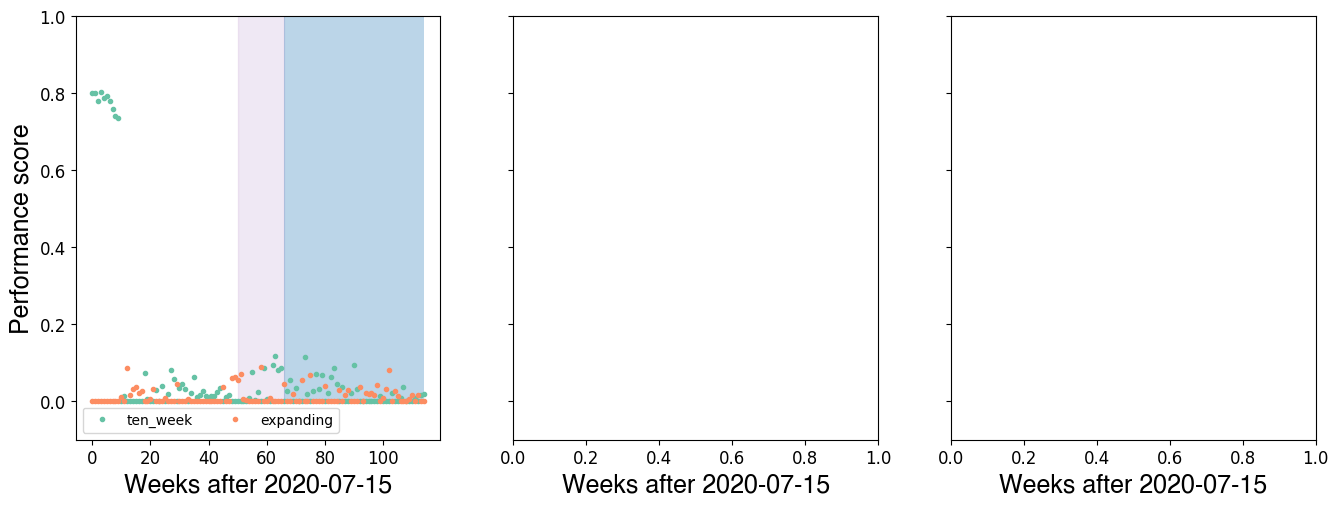

In [261]:
# Create a figure and subplots
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(16, 5.5), sharey = 'all')
weeks_to_predict_ten_week = range(10,  max(weeks_to_predict_ten_week))
for i, model in enumerate(models):
    axs[0].plot(weeks_to_predict, maximum_regret_by_model[model], label=model, marker = '.', linestyle = '', color = palette[i])
#axs[0].plot(range(0, len(percent_exceed_capacity)), percent_exceed_capacity, linewidth = 1, color = '#A0AABA', linestyle = '--')



# Add labels and legend
for i in range(len(axs)):
    axs[i].set_xlabel('Weeks after 2020-07-15',**hfont,  fontsize = 18 )
    axs[i].tick_params(axis='both', which='major', labelsize=12)
    polygon_delta = Polygon([(first_week_delta, 0), (first_week_delta, 100000), (last_week_delta, 100000), (last_week_delta, 0)],
                      alpha=0.3, color = '#cdb4db')
    axs[i].add_patch(polygon_delta)
    polygon_omricon = Polygon([(first_week_omricon, 0), (first_week_omricon, 100000), (last_week_omricon, 100000), (last_week_omricon, 0)],
                        alpha=0.3)
    axs[i].add_patch(polygon_omricon)

axs[0].set_ylabel('Performance score',**hfont,  fontsize = 18)
axs[0].set_ylim(-.1,1)
#add_labels_to_subplots(axs, hfont, 1.01, 24)
axs[0].legend(ncol = 2, loc='lower left')


# General comparison of metrics

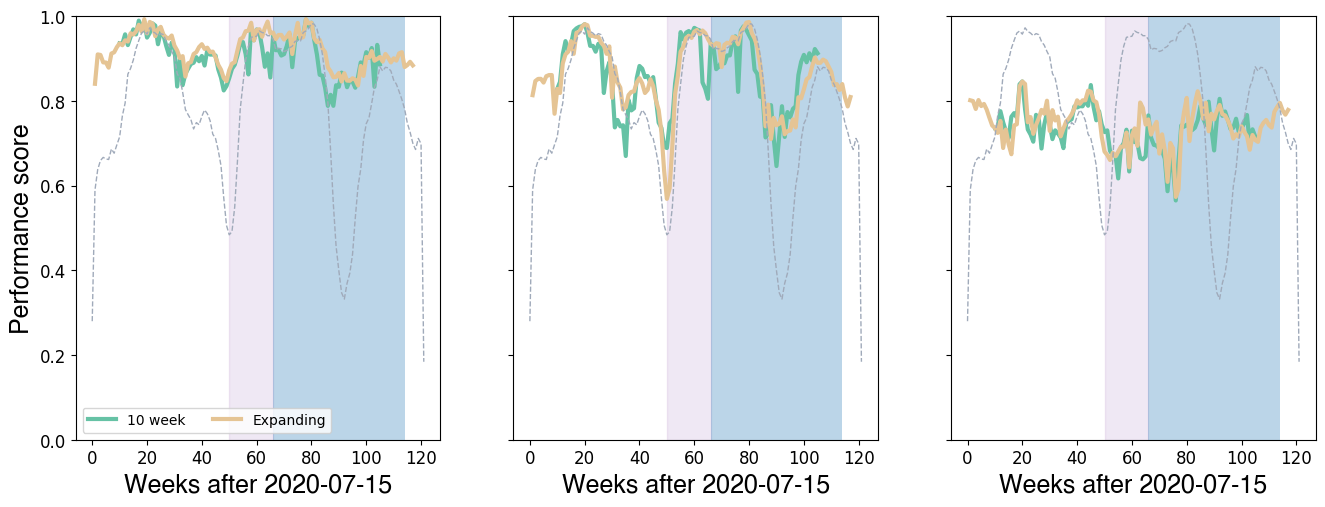

In [141]:
# Create a figure and subplots
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(16, 5.5), sharey = 'all')
weeks_to_predict_ten_week = range(10,  max(weeks_to_predict_ten_week))
axs[0].plot(weeks_to_predict_ten_week, ROC_by_week_full_period_10_week[0:len(weeks_to_predict_ten_week)], label='10 week', linewidth = 3, color = palette[0])
#axs[0].plot(weeks_to_predict, ROC_by_week_full_period_26_week[0:len(weeks_to_predict)], label='26 week', linewidth = 3, color = palette[1])
axs[0].plot(weeks_to_predict_expanding, ROC_by_week_full_period_expanding[0:len(weeks_to_predict_expanding)], label='Expanding', linewidth = 3, color = palette[5])
axs[0].plot(range(0, len(percent_exceed_capacity)), percent_exceed_capacity, linewidth = 1, color = '#A0AABA', linestyle = '--')

axs[1].plot(weeks_to_predict_ten_week, accuracy_by_week_full_period_10_week[0:len(weeks_to_predict_ten_week)], label='10 week', linewidth = 3, color = palette[0])
#axs[1].plot(weeks_to_predict, accuracy_by_week_full_period_26_week[0:len(weeks_to_predict)], label='26 week', linewidth = 3, color = palette[1])
axs[1].plot(weeks_to_predict_expanding, accuracy_by_week_full_period_expanding[0:len(weeks_to_predict_expanding)], label='Expanding', linewidth = 3, color = palette[5])
axs[1].plot(range(0, len(percent_exceed_capacity)), percent_exceed_capacity, linewidth = 1, color = '#A0AABA', linestyle = '--')

axs[2].plot(weeks_to_predict_ten_week, norm_MCC_by_week_full_period_10_week[0:len(weeks_to_predict_ten_week)], label='10 week', linewidth = 3, color = palette[0])
#axs[2].plot(weeks_to_predict, norm_MCC_by_week_full_period_26_week[0:len(weeks_to_predict)], label='26 week', linewidth = 3, color = palette[1])
axs[2].plot(weeks_to_predict_expanding, norm_MCC_by_week_full_period_expanding[0:len(weeks_to_predict_expanding)], label='Expanding', linewidth = 3, color = palette[5])
axs[2].plot(range(0, len(percent_exceed_capacity)), percent_exceed_capacity, linewidth = 1, color = '#A0AABA', linestyle = '--')



# Add labels and legend
for i in range(len(axs)):
    axs[i].set_xlabel('Weeks after 2020-07-15',**hfont,  fontsize = 18 )
    axs[i].tick_params(axis='both', which='major', labelsize=12)
    polygon_delta = Polygon([(first_week_delta, 0), (first_week_delta, 100000), (last_week_delta, 100000), (last_week_delta, 0)],
                      alpha=0.3, color = '#cdb4db')
    axs[i].add_patch(polygon_delta)
    polygon_omricon = Polygon([(first_week_omricon, 0), (first_week_omricon, 100000), (last_week_omricon, 100000), (last_week_omricon, 0)],
                        alpha=0.3)
    axs[i].add_patch(polygon_omricon)

axs[0].set_ylabel('Performance score',**hfont,  fontsize = 18)
axs[0].set_ylim(0,1)
#add_labels_to_subplots(axs, hfont, 1.01, 24)
axs[0].legend(ncol = 2, loc='lower left')
